<a href="https://colab.research.google.com/github/blortle-dev/data-science-lasa/blob/main/Unit%206/ColiDicaU6Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Effects of Lap Number and Time of Day on Pit Stop Duration
*Unit 6 Project*

In this project, I'm going to use data from Formula 1 to model how lap number and the current hour influences the length of a pit stop.

In [1]:
# Start by importing necessary modules

import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


The data I'm using contains modern pit stop data recorded from Formula One, such as which race, which driver, which number stop, the current race lap, and the length of the pit stop from pit entry to exit. For this project, I'll use the two data columns I think have the most influence and interesting data:
- `lap` to see if stops get faster or slower throughout the race
- `time` to see if pitstop length is influenced by time of day

## Prior

For this project and from my observations, I predict that:
- Pit stops will **get slower** as the lap number gets higher, since the pit crew likely gets more tired
- Pit stops will **get faster** the closer the race time is to noon, as later races will likely result in a more tired pit crew and/or driver
- There likely won't be too much variance as pit crews tend to be pretty consistent.

I'll use these variables to make my model, with the goal of predicting the `milliseconds` value.

## Preparing our Dataset

Before building our models, we have to prepare our data. I'll do that with some brief explanations below:

In [6]:
# Importing the actual data from GitHub

data = pd.read_csv("https://raw.githubusercontent.com/blortle-dev/data-science-lasa/refs/heads/main/resources/pit_stops.csv")

In [7]:
# Get data types to make sure everything will work properly

print(data.dtypes)

raceId           int64
driverId         int64
stop             int64
lap              int64
time            object
duration        object
milliseconds     int64
dtype: object


Our data has some outliers. I'm not sure where to cut it off, so let's see where most of our data is located:

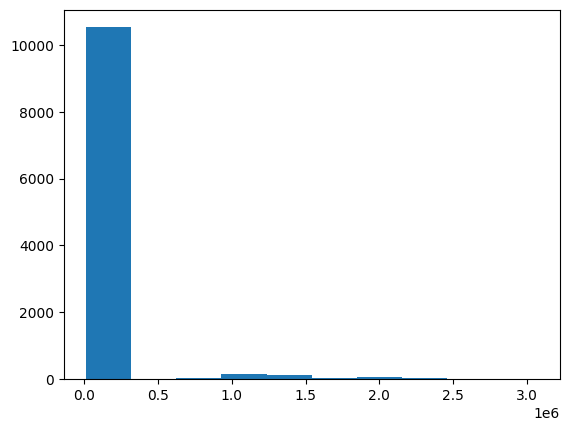

In [16]:
x_axis = data['milliseconds']
plt.hist(x=x_axis)
plt.show()

That's not too helpful. I'll cut it off a bit earlier to get a better idea.

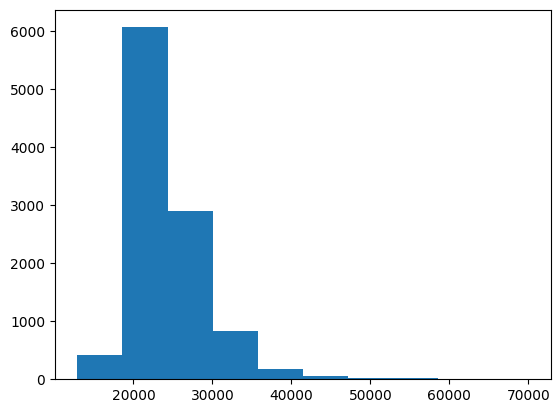

In [15]:
plt.hist(x=x_axis, range=(x_axis.min(), 70000))
plt.show()

Looks like it seems to fall off around 40,000 milliseconds. I'll cut my data off there.

In [19]:
# Remove outliers (stops longer than 40 seconds) to ensure super-long stops don't mess up our model
# If you're spending more than 20 seconds in the pit box, something's gone wrong.

data = data[data["milliseconds"] < 40000]

In [20]:
# Making sure everything looks right with our dataset

data

,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842
...,...,...,...,...,...,...,...
10985,1132,807,2,39,16:06:28,30.265,30265
10986,1132,840,2,39,16:06:33,29.469,29469
10987,1132,839,4,38,16:06:52,29.086,29086
10988,1132,815,4,47,16:20:38,28.871,28871


In [21]:
# Create the new `hour` column

try:
  data.insert(loc=0,column="hour",value=np.zeros(data.shape[0]))
except ValueError:
  print("ValueError raised, moving on...") # I added this because I kept getting a ValueError, even though the code completed fine.
except Exception as e:
  raise e

In [22]:
# Convert the new `hour` column to a numeric value

data['hour'] = pd.to_numeric(data['hour'])

C:\Users\dicar\AppData\Local\Temp\ipykernel_48656\1474317487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hour'] = pd.to_numeric(data['hour'])


In [23]:
# Extract the `hour` value from each row and assign it to the proper column

for i, item in data.iterrows():
  data.at[i, 'hour'] = round(int(item["time"][:2]))

print("Done")

Done


In [24]:
# Convert the hour column from float64 to int64

data['hour'] = data['hour'].astype('int64')

C:\Users\dicar\AppData\Local\Temp\ipykernel_48656\3184008771.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hour'] = data['hour'].astype('int64')


In [18]:
# This code took 4 hours and didn't complete, probably not the best idea to keep looping through two massive CSVs until you find the right value

if not True: # just to make sure you don't run it
  for item in data.rows:
    found = False
    foundLapLength = 0
    for reference in race_data.rows:
      if reference["raceId"] == item["raceId"]:
        found = True
        foundLapLength = reference["laps"]
        break
    if not found:
      data.drop(item)
      print("Dropped an item")
    else:
      item["lap"] = item["lap"] / foundLapLength

Now that our data is ready, we can begin:
## Making our Model

I started by making a model just comparing milliseconds to lap (similar to Unit 5), just so I would have a baseline to compare with later.
Let's import bambi and build the simple model:

In [25]:
import bambi as bmb

### Quick Notes

- `hour` is in _24 hour time_, starting with value 13, meaning _13:00_.
- `lap` is in overall laps. Shorter tracks have more laps. Remember that for later.
- `milliseconds` is from _pit entry_ to _pit exit_, driving at or below the pit lane speed limit of **80 kph**

In [28]:
model_nbb_bmb = bmb.Model("milliseconds ~ lap", data, family = "negativebinomial")
idata_nbb_bmb = model_nbb_bmb.fit(idata_kwargs={"log_likelihood":True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, lap]


BrokenPipeError: [WinError 232] The pipe is being closed

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: lap


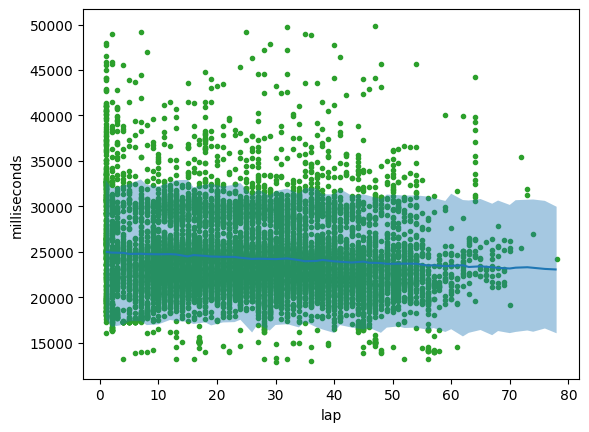

In [37]:
bmb.interpret.plot_predictions(model_nbb_bmb, idata_nbb_bmb, "lap", pps=True)
plt.plot(data.lap, data.milliseconds, "C2.", zorder=-3)

Just how I predicted, accurate, but not the most descriptive. How about a more specific one?

In [38]:
model_mlb_bmb = bmb.Model("milliseconds ~ lap + hour", data, family="negativebinomial")
idata_mlb_bmb = model_mlb_bmb.fit(idata_kwargs={"log_likelihood":True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, lap, hour]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: lap, hour


(<Figure size 640x480 with 12 Axes>,
 array([[<Axes: title={'center': 'hour = 13'}, xlabel='lap', ylabel='milliseconds'>,
         <Axes: title={'center': 'hour = 14'}, xlabel='lap', ylabel='milliseconds'>,
         <Axes: title={'center': 'hour = 15'}, xlabel='lap', ylabel='milliseconds'>],
        [<Axes: title={'center': 'hour = 16'}, xlabel='lap', ylabel='milliseconds'>,
         <Axes: title={'center': 'hour = 17'}, xlabel='lap', ylabel='milliseconds'>,
         <Axes: title={'center': 'hour = 18'}, xlabel='lap', ylabel='milliseconds'>],
        [<Axes: title={'center': 'hour = 19'}, xlabel='lap', ylabel='milliseconds'>,
         <Axes: title={'center': 'hour = 20'}, xlabel='lap', ylabel='milliseconds'>,
         <Axes: title={'center': 'hour = 21'}, xlabel='lap', ylabel='milliseconds'>],
        [<Axes: title={'center': 'hour = 22'}, xlabel='lap', ylabel='milliseconds'>,
         <Axes: title={'center': 'hour = 23'}, xlabel='lap', ylabel='milliseconds'>,
         <Axes: xlabel='l

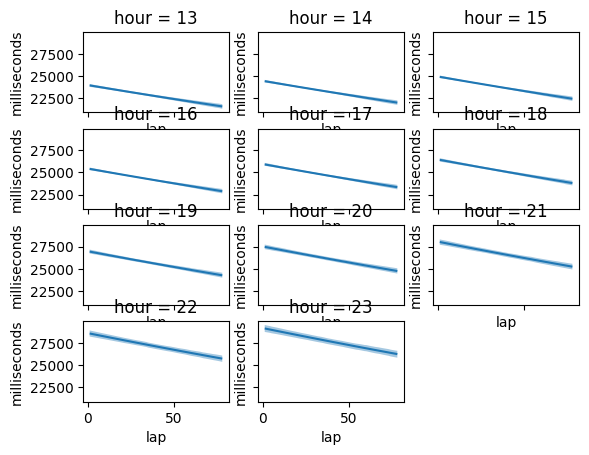

In [40]:
bmb.interpret.plot_predictions(model_mlb_bmb, idata_mlb_bmb, ["lap", "hour"],
                               subplot_kwargs={"group":None, "panel":"hour"},
                               legend=False,
                               fig_kwargs={"sharey":True, "sharex":True})

This looks like it will be interesting. Let's graph them all together to get a better look at the model:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: lap, hour


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='lap', ylabel='milliseconds'>], dtype=object))

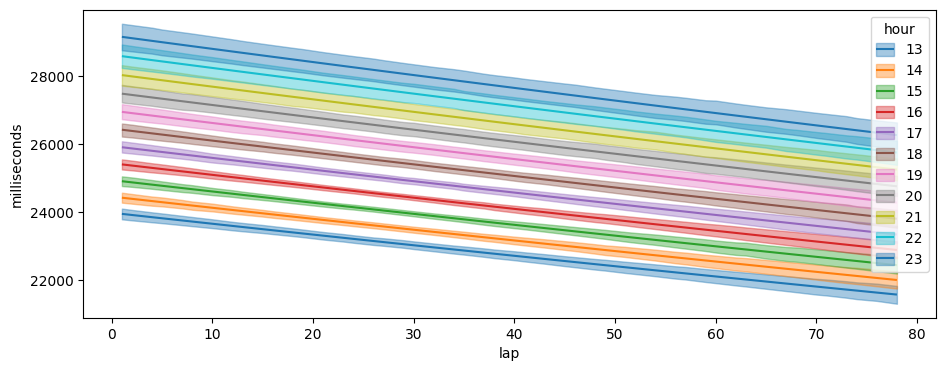

In [41]:
bmb.interpret.plot_predictions(model_mlb_bmb,
                               idata_mlb_bmb,
                               ["lap",  "hour"], fig_kwargs={"figsize":(11, 4)})

As we can see, the stops seem to get slower the later in the day (as predicted), but faster the later into the race. But why?

My guess is this model is a bit inaccurate. While we are _technically_ analyzing the pitstop length vs lap + hour, this model fails to take a lot into account:
- As stated in the introduction, the `milliseconds` measures the duration from pit entry to pit exit, which **doesn't** account for the length of the pitlane.
    - Each circuit has a different length pit lane with, in turn, different time losses from just driving at the speed limit.
    - Since there's nearly a **five second** difference, my guess is that races that race later in the day tend to have longer pitlanes, which is definitley an interesting piece of data that I stumbled upon.
- Also, there are a lot of outside factors that influence pit stops, from the pit crew to driver, or even the temperature.
- Longer races (as in more laps) tend to have shorter tracks, which means a shorter pitlane. This could explain the decrease in time in later laps, as long circuits, such as Spa-Francorchamps, have less laps (\~50) than shorter tracks like the Red Bull Ring (\~75 laps).

Now that we've gone over a few of the issues with this model, I've come to the conclusion that it's not a very accurate model considering all factors, but it's the best I can do with the data I have access to. How's this look with a scatter plot, though?

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: lap, hour


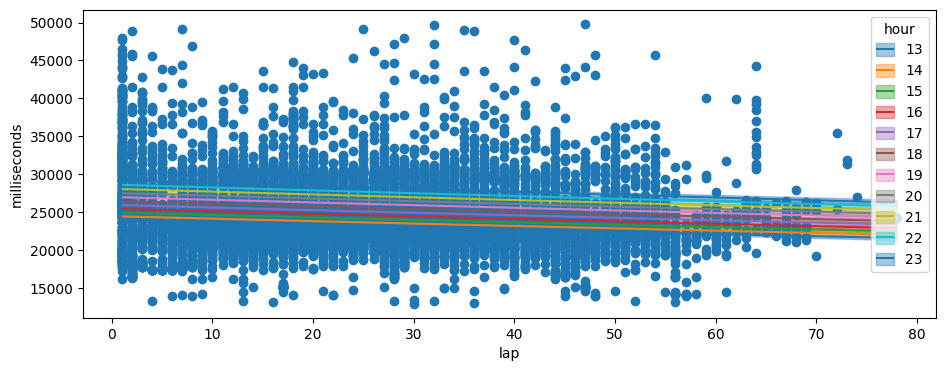

In [42]:
# PLOT SCATTER PLOT

#model_pitstop = bmb.Model("milliseconds ~ lap + hour", data=data)
#idata_pitstop = model_pitstop.fit(idata_kwargs={'log_likelihood': True})
bmb.interpret.plot_predictions(model_mlb_bmb,
                               idata_mlb_bmb,
                               ["lap",  "hour"], fig_kwargs={"figsize":(11, 4)})
plt.scatter(x="lap", y="milliseconds", data=data)
#data.plot(x="lap", y="milliseconds", figsize=(12, 4), kind="scatter")
# PLOT HDI

😬 Looks like there's not too much variance in the model, as predicted. F1 pit crews practice _a lot_, and tend to be pretty consistent. This isn't really surprising at all. I'll give my final thoughts in the conclusion.

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

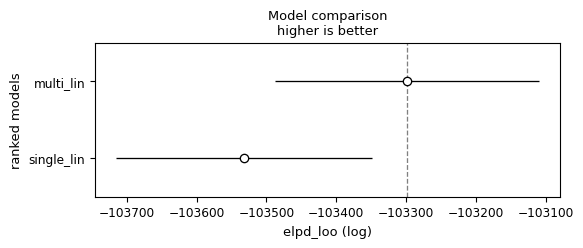

In [17]:
# Model comparison between single and multi models

cmp_df = az.compare( {"multi_lin":idata_mlb_bmb,"single_lin":idata_nbb_bmb} )

az.plot_compare(cmp_df)

## Conclusion

Well, that was disappointing. Turns out, the model kind of just ended up predicting trends with circuits rather than pit stop duration. With how consistent pit crews are, there's a good chance that most factors don't have a big influence on pitstop length. So what is the largest influence? My guess is random issues. From mechanical issues to a missed tyre, these random failures or mistakes (could be correlated with stress, no way to measure that though) are likely the largest influence in pitstop duration, much more significantly than any other factor.